<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jaime\AppData\Local\Temp\ipykernel_50356\2714277671.py:84: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon \\text{ }(-)$')
C:\Users\Jaime\AppData\Local\Temp\ipykernel_50356\2714277671.py:85: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{S} \\text{ }(kPa\cdot m^3/kg)$')


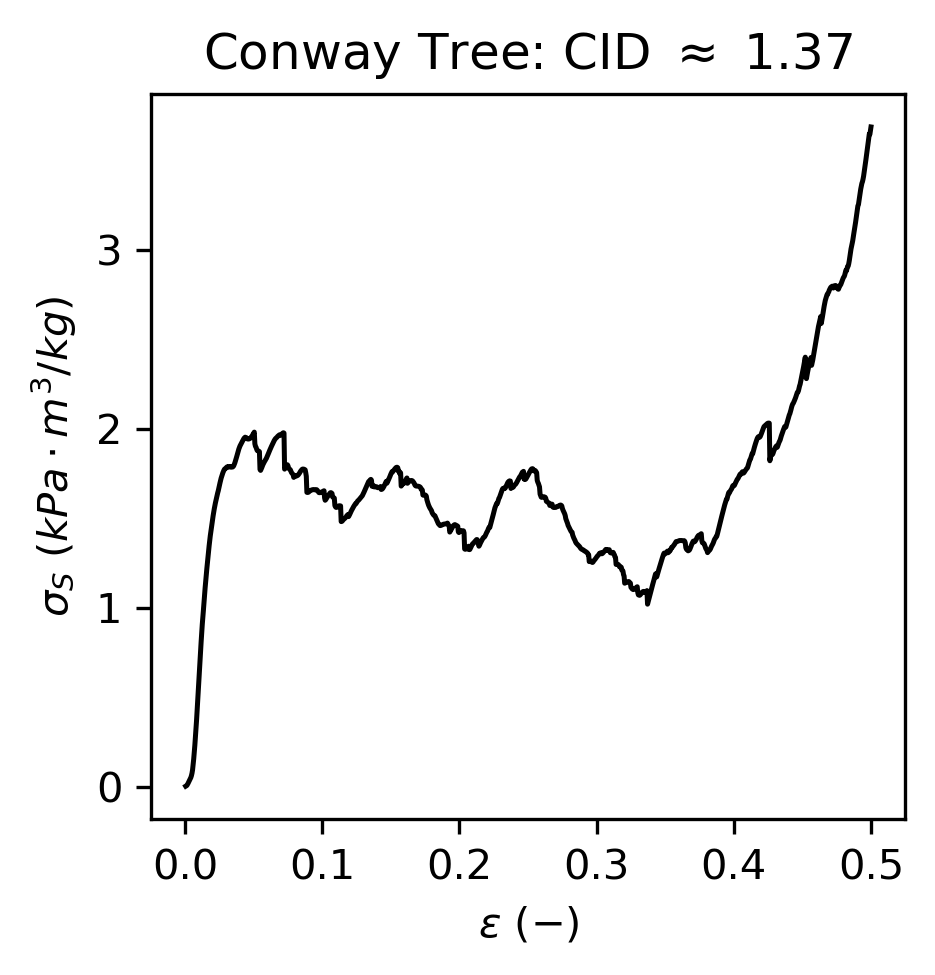

In [2]:
#!/usr/bin/env python
# coding: utf-8
"""
Minimal plotter: specific compressive stress vs. engineering strain
===================================================================
• Reads every “Test Run <n>” sub-folder in `main_folder_path`
• Computes strain, stress, and specific stress
• Plots a single curve for each run (no peak markers, no overlays)
• Saves PNGs to `Data/Crack_Arrest_Notebook_Saves/`
"""

# ───── imports ──────────────────────────────────────────────────
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ───── constants ────────────────────────────────────────────────
L0_MM      = 36.0          # gauge length in mm
SIDE_MM    = 30.0          # cross-section side length in mm
AREA_M2    = (SIDE_MM*1e-3) ** 2     # m²
VOXEL_SIDE = 1.0           # mm (voxel edge length assumed 1 mm)
PLA_DENS_G_CM3 = 1.25
DENS_KG_MM3    = PLA_DENS_G_CM3 * 1e-6   #  g → kg, cm⁻³ → mm⁻³
NET_VOL_MM3    = SIDE_MM**3              # printed cube, mm³
SAVE_DIR  = 'Data/Crack_Arrest_Notebook_Saves'
MAIN_DIR  = 'Data/MTS_Runs'

# sample metadata (unchanged; gives Voxel Count per run)
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156, 
            1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423, 
            1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222, 
            0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}

vox_df = pd.DataFrame(sample_data).set_index('Run Number')

# ───── helpers ──────────────────────────────────────────────────
rx_run = re.compile(r'Test Run (\d+)', re.I)
def run_num(folder_name:str) -> int|None:
    m = rx_run.search(folder_name);  return int(m.group(1)) if m else None

# ───── I/O setup ────────────────────────────────────────────────
os.makedirs(SAVE_DIR, exist_ok=True)

subfolders = [f.path for f in os.scandir(MAIN_DIR) if f.is_dir()]
runs = sorted( (run_num(os.path.basename(f)), f) for f in subfolders if run_num(os.path.basename(f)) )

# pick the run we care about
SELECTED_RUN = 11         # change this if you want another sample

# ─── main loop ────────────────────────────────────────────────
for run_id, folder in runs:
    if run_id != SELECTED_RUN:
        continue                          # skip all other runs

    dat_file = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    if not os.path.isfile(dat_file):
        raise FileNotFoundError(f"Data file missing for run {run_id}")

    # ── load & compute ────────────────────────────────────────
    df = pd.read_csv(dat_file, sep='\t', skiprows=7)
    df['strain']  = (df['mm'] * 1e-3) / (L0_MM*1e-3)
    df['stress']  = (df['kN'] * 1e3) / AREA_M2

    # specific stress
    voxels = vox_df.loc[run_id, 'Voxel Count']
    mass_kg = voxels * DENS_KG_MM3 * VOXEL_SIDE**3
    # inside the loop, right after you compute `mass_kg`
    volume_m3        = NET_VOL_MM3 * 1e-9          # mm³ ➜ m³
    density_kgm3     = mass_kg / volume_m3         # kg / m³
    df['specific_stress_kPa'] = (df['stress'] / density_kgm3) / 1e3  # kPa·m³/kg

    # plot
    cid_val = vox_df.loc[run_id, 'CID']
    plt.figure(figsize=(3.35,3.35), dpi=300) #single column figure dimensions as per:
    '''https://advanced.onlinelibrary.wiley.com/hub/journal/15214095/author-guidelines#:~:text=Figures%20and%20tables%20should%20have,be%20submitted%20in%20separate%20files.'''
    plt.plot(df['strain'], df['specific_stress_kPa'], 'k-', lw=1.2)
    plt.xlabel('$\epsilon \\text{ }(-)$')
    plt.ylabel('$\sigma_{S} \\text{ }(kPa\cdot m^3/kg)$')
    plt.title(rf'Conway Tree: CID $\approx$ {float(cid_val):.3g}')
    plt.tight_layout()
    plt.ticklabel_format(style='plain', axis='y')   # no scientific-notation offset
    plt.show()

    break        

Now plotting all specific stress-strain figs in one:

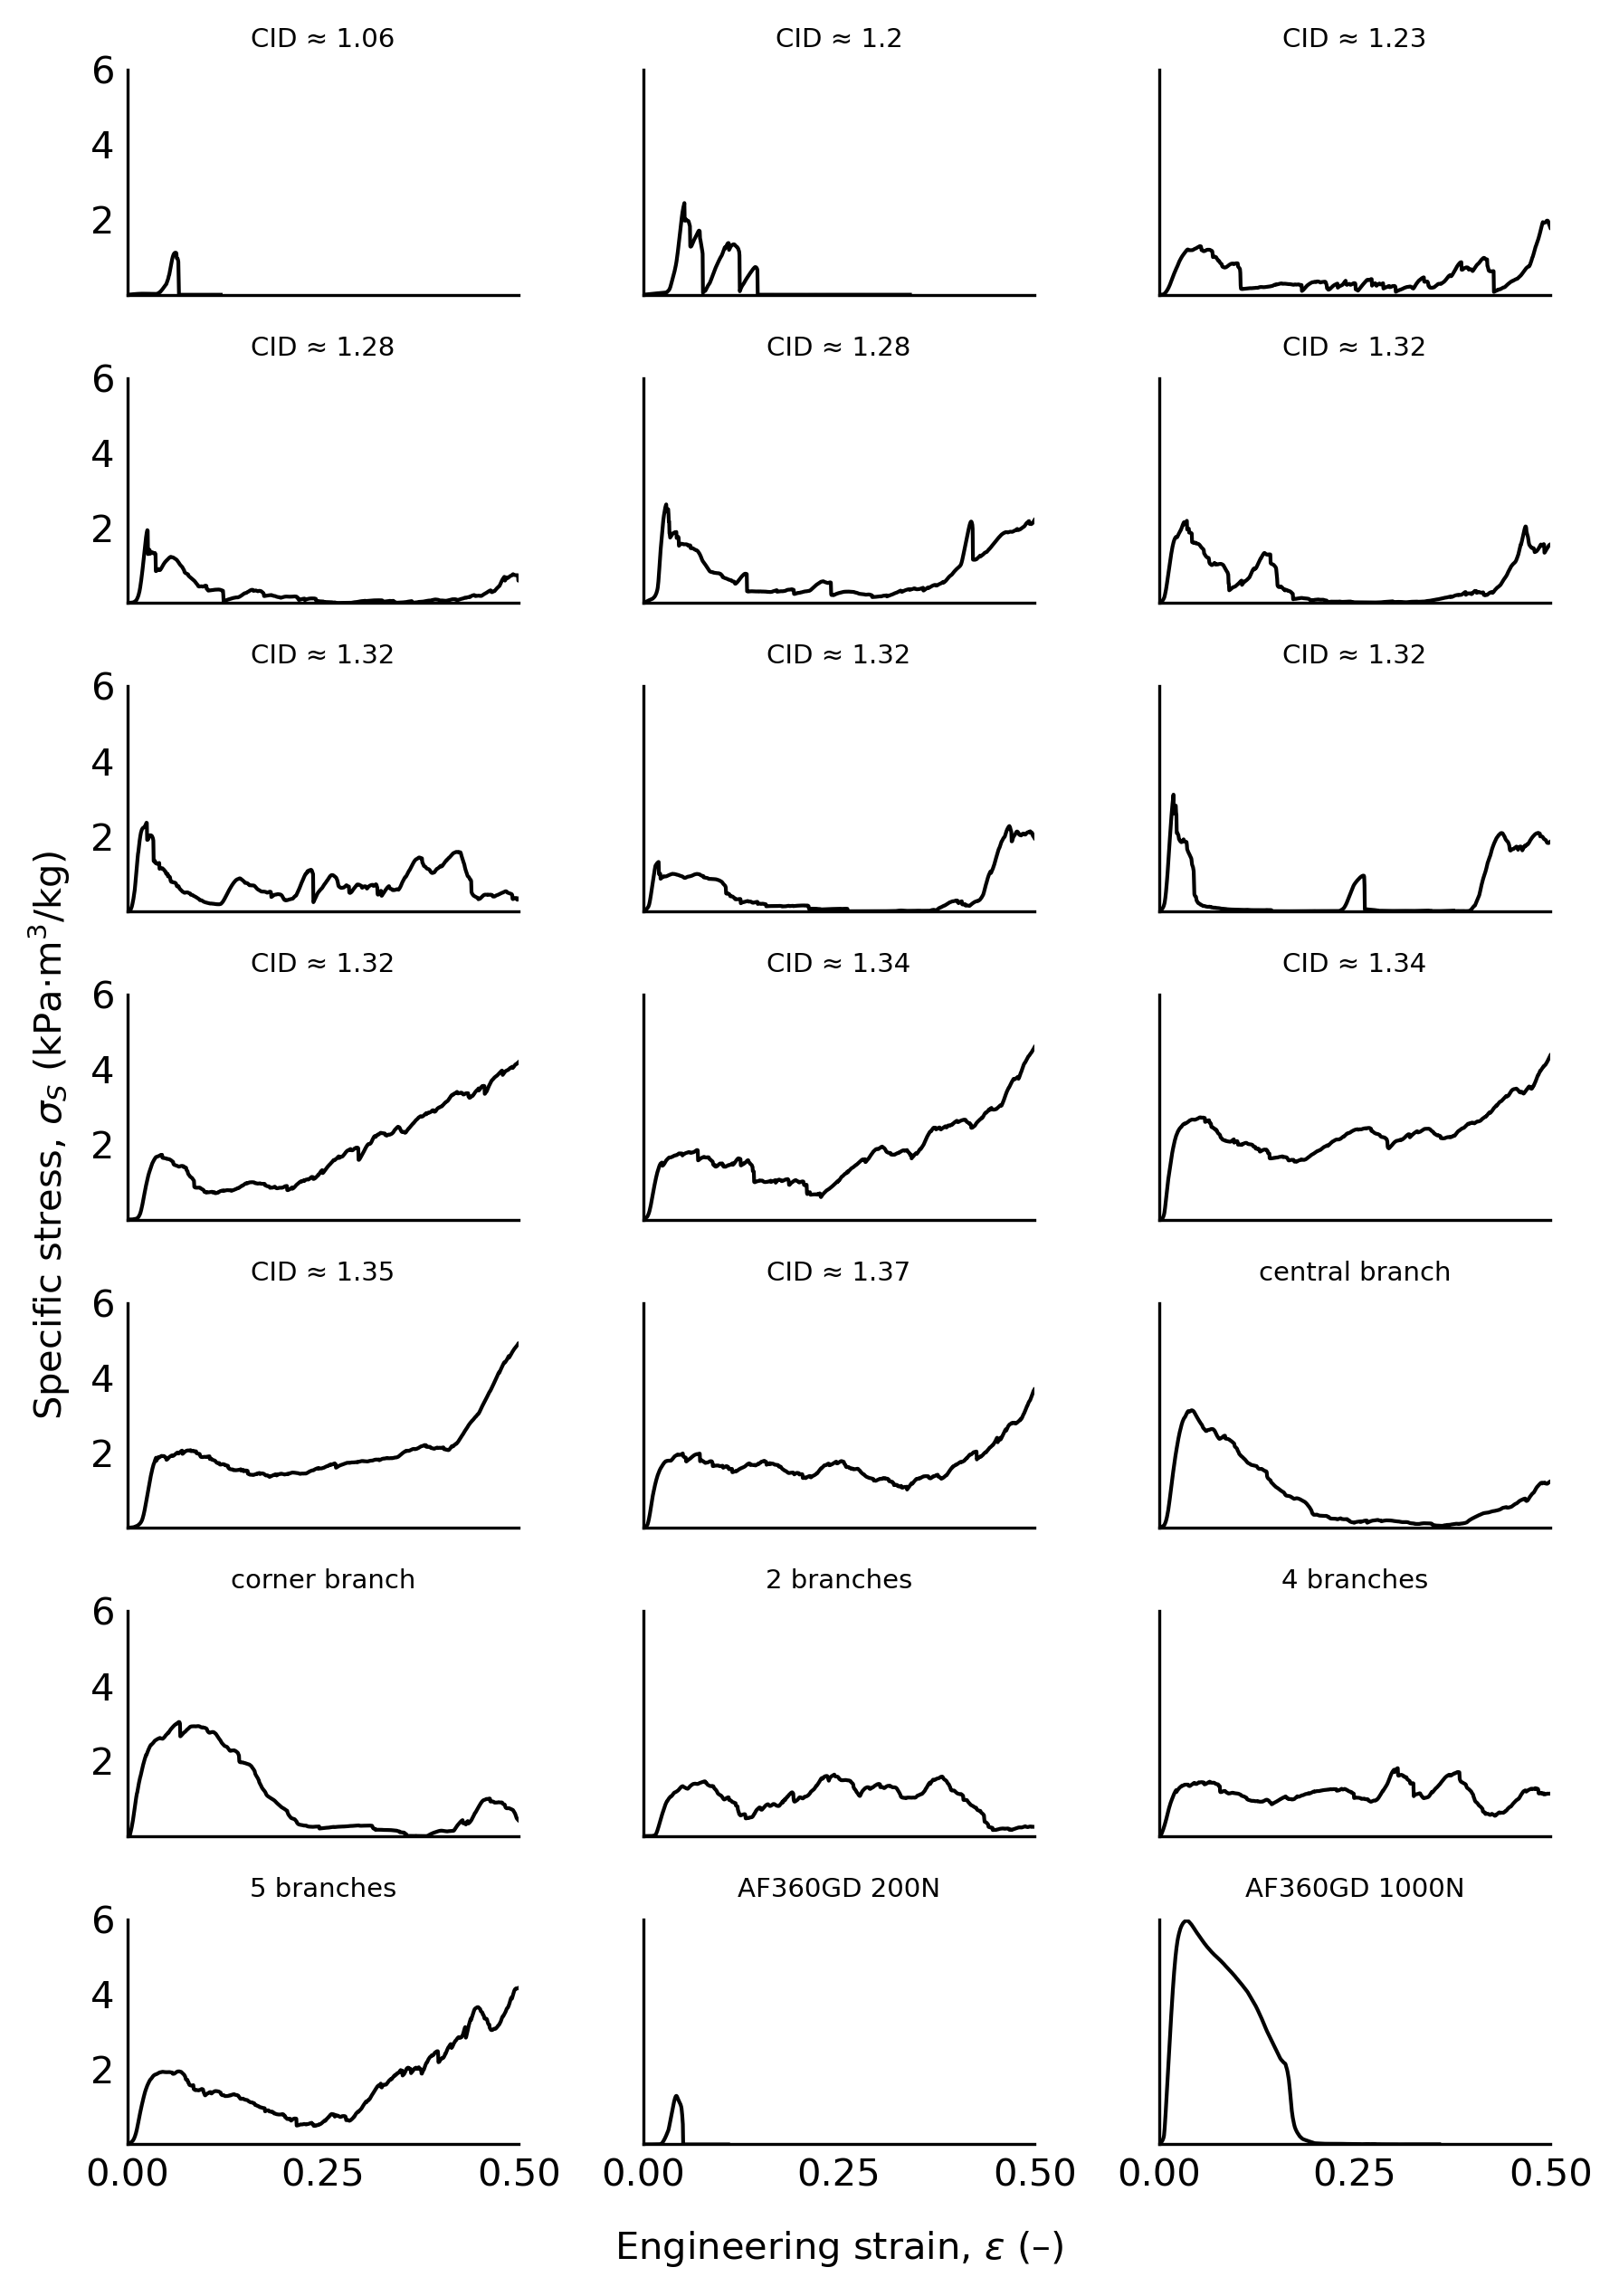

Saved ➜ Data/Crack_Arrest_Notebook_Saves/stress_strain_subplots_ordered.png


In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Specific compressive stress vs. engineering strain — ordered sub-figure grid
============================================================================
• One black curve per run, arranged 3-wide to fit 6.5″ × 9″ page (1″ margins)
• Normal CTs ordered by ascending CID, followed by branches, then Fusion 360
"""

import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# ───── constants ────────────────────────────────────────────────
L0_MM, SIDE_MM = 36.0, 30.0
AREA_M2        = (SIDE_MM * 1e-3) ** 2
PLA_DENS_G_CM3 = 1.25
DENS_KG_MM3    = PLA_DENS_G_CM3 * 1e-6
NET_VOL_MM3    = SIDE_MM ** 3
VOXEL_SIDE     = 1.0                              # mm

# ── axis range, ticks, and tick-mark styling ────────────────────
X_LIM   = (0.00, 0.50)
Y_LIM   = (0.00, 6.00)

XTICKS  = [0.00, 0.25, 0.50]          # ensure 0.25 shows
YTICKS  = [0, 2, 4, 6]                # ensure 6 shows


MAIN_DIR = 'Data/MTS_Runs'
SAVE_DIR = 'Data/Crack_Arrest_Notebook_Saves'
os.makedirs(SAVE_DIR, exist_ok=True)

# ───── sample metadata ──────────────────────────────────────────
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18,
                    'central branch', 'corner branch', '2 branches',
                    '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number':  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    22, 21, 24, 20, 23, 19, 18],
    'CID':         [1.3512, 1.3244, 1.2799, 1.2000, 1.0578, 1.3156,
                    1.3244, 1.3689, 1.3156, 1.2268, 1.3423, 1.3423,
                    1.3156, 1.2799, 0.4178, 0.4411, 0.5811, 0.8222,
                    0.9688, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1081, 3128, 4389, 5500, 2569,
                    1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983,
                    4305, 4059, 3809]
}
vox_df = pd.DataFrame(sample_data).set_index('Run Number')

# ───── helper to extract run number from folder name ────────────
rx_run = re.compile(r'Test Run (\d+)', re.I)
def run_num(folder): 
    m = rx_run.search(folder);  return int(m.group(1)) if m else None

# ───── gather all valid runs on disk ────────────────────────────
folders = {run_num(os.path.basename(p)): p
           for p in os.scandir(MAIN_DIR) if p.is_dir() and run_num(p.name)}

# ───── construct the requested ordering ─────────────────────────
normal_mask  = vox_df['Sample Name'].apply(lambda s: isinstance(s, (int, np.integer)) or str(s).isdigit())
normal_cts   = vox_df[normal_mask].sort_values('CID')
branch_order = ['central branch', 'corner branch', '2 branches', '4 branches', '5 branches']
af360_order  = ['AF360GD 200N', 'AF360GD 1000N']

def run_for_name(name):
    row = vox_df[vox_df['Sample Name'] == name]
    return int(row.index[0]) if not row.empty else None

run_sequence = list(normal_cts.index)                                   # ascending CID
run_sequence += [run_for_name(n) for n in branch_order]
run_sequence += [run_for_name(n) for n in af360_order]
run_sequence = [r for r in run_sequence if r in folders]                # keep only existing

# ───── figure setup ──────────────────────────────────────────────
n_runs  = len(run_sequence)
n_cols  = 3
n_rows  = math.ceil(n_runs / n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(6.5, 9.0), dpi=300,
                         sharex=True, sharey=True)
axes = axes.flatten()

# ───── plotting loop ────────────────────────────────────────────
for ax_idx, run_id in enumerate(run_sequence):
    ax = axes[ax_idx]
    data_file = os.path.join(folders[run_id], 'DAQ- Crosshead, … - (Timed).txt')
    if not os.path.isfile(data_file):
        ax.set_visible(False)
        print(f'[warning] missing data for run {run_id}')
        continue

    df = pd.read_csv(data_file, sep='\t', skiprows=7)
    df['strain'] = (df['mm'] * 1e-3) / (L0_MM * 1e-3)
    df['stress'] = (df['kN'] * 1e3) / AREA_M2

    voxels  = vox_df.loc[run_id, 'Voxel Count']
    mass_kg = voxels * DENS_KG_MM3 * VOXEL_SIDE**3
    density = mass_kg / (NET_VOL_MM3 * 1e-9)
    df['specific_stress_kPa'] = (df['stress'] / density) / 1e3

    # title logic
    sname = vox_df.loc[run_id, 'Sample Name']
    cid   = vox_df.loc[run_id, 'CID']
    title = (rf'CID ≈ {float(cid):.3g}' if (isinstance(sname, (int, np.integer))
             or str(sname).isdigit()) else str(sname))
    ax.plot(df['strain'], df['specific_stress_kPa'], color='k', lw=1.0)
    ax.set_title(title, fontsize=7)
    ax.spines[['top', 'right']].set_visible(False)

for ax in axes[:n_runs]:

    # fixed limits
    ax.set_xlim(X_LIM)
    ax.set_ylim(Y_LIM)

    # assign major ticks
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS)

    # hide tick *marks* but keep text labels
    ax.tick_params(axis='both', which='both', length=0)

    # remove duplicate y-axis “0” label
    ylabels = ['' if v == 0 else f'{v:g}' for v in YTICKS]
    ax.set_yticklabels(ylabels)

# ───── global labels & layout ───────────────────────────────────
fig.text(0.5, 0.04, r'Engineering strain, $\varepsilon$ (–)', ha='center')
fig.text(0.04, 0.5, r'Specific stress, $\sigma_S$ (kPa·m$^3$/kg)', va='center',
         rotation='vertical')
# fig.suptitle('Specific compressive stress vs. engineering strain', y=0.995,
#              fontsize=9)
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.97])   # leave margin for labels

# ───── save & show ──────────────────────────────────────────────
out_png = os.path.join(SAVE_DIR, 'stress_strain_subplots_ordered.png')
fig.savefig(out_png, dpi=300)
plt.show()
print(f'Saved ➜ {out_png}')